# Diffusion model
Discovery for the Master IS research project - Charbonnier Frédéric, Clerc Joël - 2023  
In the context of images, the principle of diffusion models is to add Gaussian noise to an image $x_{0}$ gradually over T steps. Then, using a neural network, the denoising function is predicted, in order to return to the image $x_{0}$.

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

First, we try to implement the noise function.
We need to add Gaussian noise to the input image $x_{0}$ step by step (Markov Chain).  
$T$ is the total number of steps.

$q(x_{t}|x_{t-1})=\mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1},\beta_{t}I) \\q(x_{1:T}|x_{0})=\prod_{t=1}^{T}q(x_{t}|x_{t-1})$

In [7]:
T = 300
BETA_MIN = 1e-4
BETA_MAX = 2e-2
BETA = torch.linspace(BETA_MIN, BETA_MAX, steps=T)
BETA_SQRT = torch.sqrt(BETA)
ALPHA = 1 - BETA
ALPHA_SQRT = torch.sqrt(ALPHA)
ALPHA_BAR = torch.cumprod(ALPHA,0)
ALPHA_BAR_SQRT = torch.sqrt(ALPHA_BAR)

print(torch.square((1-BETA)[0]))

def add_noise_stage(x,t) :
    mean = ALPHA_SQRT[t]*x
    std = BETA_SQRT[t]
    x = mean + std*torch.randn_like(x)
    return x

tensor(0.9998)


Load and visualize MNISTFashion Dataset

In [8]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=0.5,
                                                   std=0.5),
                             ])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Test adding noise

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])


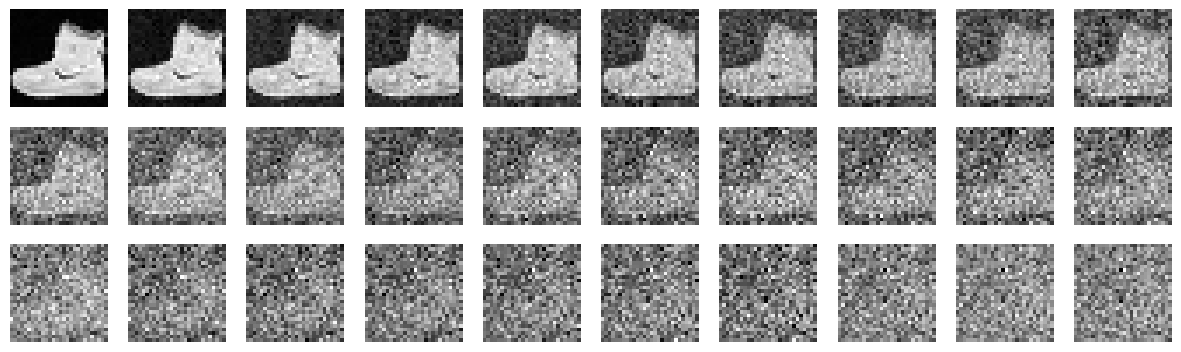

In [9]:
img, label = training_data[0]
x_init = torch.reshape(img, (-1,))

figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
i = 0
x = x_init
print(x[0:10])
for t in range(1, T):
    x = add_noise_stage(x,t)
    if (t == 1 or t % 10 == 0):
        i+=1
        figure.add_subplot(rows, cols, i)
        #plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(torch.reshape(x, (1,28,28)).squeeze(), cmap="gray")

Implemente parametrize trick.

$x_{t}=\sqrt{\alpha_{t}}x_{t-1}+\sqrt{1-\alpha_{t}} \epsilon_{t-1}\\=\sqrt{\alpha_{t}\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_{t}\alpha_{t-1}} \bar{\epsilon}_{t-2}\\=\text{...}\\=\sqrt{\bar{\alpha}_{t}}x_{0}+\sqrt{1-\bar{\alpha}_{t}}\epsilon \\\alpha_{t}=1-\beta_{t}, \bar{\alpha}_{t}=\prod_{t=1}^{T}\alpha_{t}$

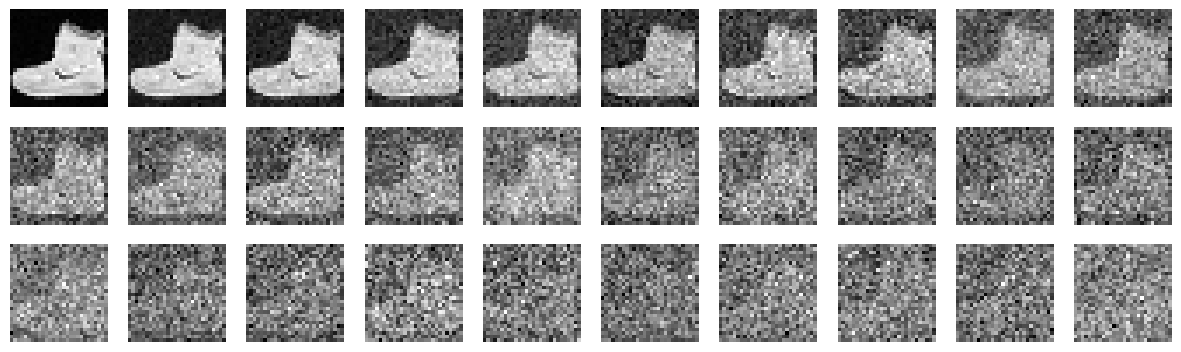

In [10]:
def add_noise_directly(x_init,t) :
    mean = ALPHA_BAR_SQRT[t]*x_init
    std = torch.sqrt(1-ALPHA_BAR[t])
    x = mean + std*torch.randn_like(x_init) 
    return x

figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
i = 0
for t in range(1, T):
    if (t == 1 or t % 10 == 0):
        x = add_noise_directly(x_init,t)
        i+=1
        figure.add_subplot(rows, cols, i)
        #plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(torch.reshape(x, (1,28,28)).squeeze(), cmap="gray")

Test calculate posterior $q(x_{t-1}|x_{t},x{0})$